# Sci-kit Learn Titanic Classification

This exercise will explore the extensive data of documented people on the Titanic. Using machine learning and kNN tracing, the following analysis will attempt to see which attributes are predictive of survival.

## Collect/Clean/Prepare Data

Before any kNN tracing can be done on this extensive dataset, the dataset needs to be uploaded into a dataframe for cleaning and preparation. Since `"PassengerId"` is a unique attribute in the dataset, it will be the index.

In [61]:
import pandas as pd

titanic_df = pd.read_csv("titanic.csv", index_col="PassengerId")
print(titanic_df.columns)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')


Now that the dataframe is uploaded, it is time to drop columns that will not be informative to survival predictions. Columns that are unique to every passenger in addition to the passenger ID are considered unnecessary. Likewise, columns that do not influence survival odds can be dropped as well. The following columns will be dropped:

* Name
* Ticket
* Cabin
* Embarked

In [62]:
titanic_df.drop("Name", axis=1, inplace=True)
titanic_df.drop("Ticket", axis=1, inplace=True)
titanic_df.drop("Cabin", axis=1, inplace=True)
titanic_df.drop("Embarked", axis=1, inplace=True)

print(titanic_df.head(5))

             Survived  Pclass     Sex   Age  SibSp  Parch     Fare
PassengerId                                                       
1                   0       3    male  22.0      1      0   7.2500
2                   1       1  female  38.0      1      0  71.2833
3                   1       3  female  26.0      0      0   7.9250
4                   1       1  female  35.0      1      0  53.1000
5                   0       3    male  35.0      0      0   8.0500


Another piece of preparation that needs to be completed is the conversion of categorical features. The only remaining categorical feature is sex, which can be numerically identified with an assigned number. Sci-kit learn's Label Encoder will be used to do this:

In [63]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(titanic_df["Sex"])
list(le.classes_)
titanic_df["Sex"] = le.transform(titanic_df["Sex"])

print(titanic_df.head(5))

             Survived  Pclass  Sex   Age  SibSp  Parch     Fare
PassengerId                                                    
1                   0       3    1  22.0      1      0   7.2500
2                   1       1    0  38.0      1      0  71.2833
3                   1       3    0  26.0      0      0   7.9250
4                   1       1    0  35.0      1      0  53.1000
5                   0       3    1  35.0      0      0   8.0500


From this label encoder, the sex of each passenger has now been assigned a numeric value. The following codes below correspond to the new numeric label:

* Female: 0
* Male: 1

The last part of the data preparation is to check to see if there are any other missing values within the dataframe. If there are, the row must be deleted.

In [64]:
titanic_df.dropna(axis=0, inplace=True)

for i in range(len(titanic_df.columns)):
    print("Null value column", i, "count:", titanic_df.iloc[i].isnull().sum())

Null value column 0 count: 0
Null value column 1 count: 0
Null value column 2 count: 0
Null value column 3 count: 0
Null value column 4 count: 0
Null value column 5 count: 0
Null value column 6 count: 0


## Exploratory Data Analysis

Now that the data has been successfully cleaned, data analysis can be performed to identify potential trends among dataset attributes. In order to identify these trends the following exploratory tactics will be used:

* Data Grouping
* Data Visualizations
* Hypothesis testing
* Decision Tree Classifier

### Data Grouping

The first statistical analysis will provide summary stats to compare between the passengers that survived and the ones that did not. Functions like `get_group()` and `describe()` will be used to carry this out:

In [65]:
survivor_grouped_df = titanic_df.groupby("Survived")

did_not_survive_group = survivor_grouped_df.get_group(0)
print("DID NOT SURVIVE SUMMARY STATS\n", did_not_survive_group.describe())

DID NOT SURVIVE SUMMARY STATS
        Survived      Pclass         Sex         Age       SibSp       Parch  \
count     424.0  424.000000  424.000000  424.000000  424.000000  424.000000   
mean        0.0    2.485849    0.849057   30.626179    0.525943    0.365566   
std         0.0    0.743633    0.358417   14.172110    1.044760    0.878341   
min         0.0    1.000000    0.000000    1.000000    0.000000    0.000000   
25%         0.0    2.000000    1.000000   21.000000    0.000000    0.000000   
50%         0.0    3.000000    1.000000   28.000000    0.000000    0.000000   
75%         0.0    3.000000    1.000000   39.000000    1.000000    0.000000   
max         0.0    3.000000    1.000000   74.000000    5.000000    6.000000   

             Fare  
count  424.000000  
mean    22.965456  
std     31.448825  
min      0.000000  
25%      7.895800  
50%     11.887500  
75%     26.550000  
max    263.000000  


In [66]:
survived_group = survivor_grouped_df.get_group(1)
print("SURVIVED SUMMARY STATS:\n", survived_group.describe())

SURVIVED SUMMARY STATS:
        Survived      Pclass         Sex         Age       SibSp       Parch  \
count     290.0  290.000000  290.000000  290.000000  290.000000  290.000000   
mean        1.0    1.872414    0.320690   28.343690    0.493103    0.527586   
std         0.0    0.836617    0.467548   14.950952    0.731132    0.807147   
min         1.0    1.000000    0.000000    0.420000    0.000000    0.000000   
25%         1.0    1.000000    0.000000   19.000000    0.000000    0.000000   
50%         1.0    2.000000    0.000000   28.000000    0.000000    0.000000   
75%         1.0    3.000000    1.000000   36.000000    1.000000    1.000000   
max         1.0    3.000000    1.000000   80.000000    4.000000    5.000000   

             Fare  
count  290.000000  
mean    51.843205  
std     70.458776  
min      0.000000  
25%     13.000000  
50%     26.250000  
75%     66.200000  
max    512.329200  


### Data Visualizations

Now that there are some stats to think about for trends, there are a couple of relationships that stand out between those that survived and those that did not. One drastic change is the difference in ticket class for those who survived compared to those who did not. To depict this, a bar chart depicting the survivors of each class will be drawn up:

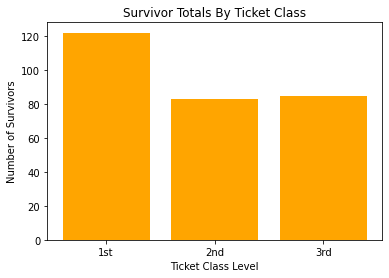

In [67]:
import matplotlib.pyplot as plt

survived_pclass_df = survived_group.groupby("Pclass")

class1_df = survived_pclass_df.get_group(1)
class2_df = survived_pclass_df.get_group(2)
class3_df = survived_pclass_df.get_group(3)

class_x = ["1st", "2nd", "3rd"]
class_list = [class1_df["Survived"].count(), class2_df["Survived"].count(), class3_df["Survived"].count()]

plt.figure()
plt.bar(class_x, class_list, color="orange")
plt.title("Survivor Totals By Ticket Class")
plt.ylabel("Number of Survivors")
plt.xlabel("Ticket Class Level")
plt.show()


It is apparent from this first bar graph that there is a significantly larger survivor total for first class members compared to those of second and third class.

The next data visualization will analyze the comparison of male survivors to female survivors. The statistical summary showed a drastic difference in the numbers for different genders. The following chart below takes a deeper look into this analysis:

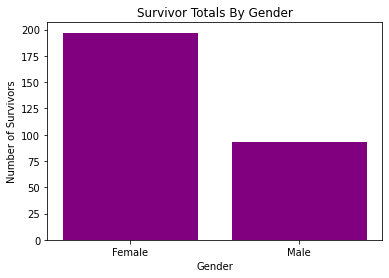

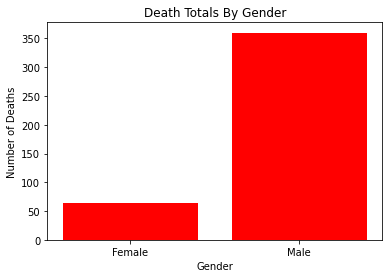

In [68]:
import matplotlib.pyplot as plt

survived_gender_df = survived_group.groupby("Sex")

female_survived_df = survived_gender_df.get_group(0)
male_survived_df = survived_gender_df.get_group(1)

gender_x = ["Female", "Male"]
gender_list = [female_survived_df["Survived"].count(), male_survived_df["Survived"].count()]

plt.figure()
plt.bar(gender_x, gender_list, color="purple")
plt.title("Survivor Totals By Gender")
plt.ylabel("Number of Survivors")
plt.xlabel("Gender")
plt.show()

no_survivor_gender_df = did_not_survive_group.groupby("Sex")

female_no_survived_df = no_survivor_gender_df.get_group(0)
male_no_survived_df = no_survivor_gender_df.get_group(1)

gender_x = ["Female", "Male"]
death_gender_list = [female_no_survived_df["Survived"].count(), male_no_survived_df["Survived"].count()]

plt.figure()
plt.bar(gender_x, death_gender_list, color="red")
plt.title("Death Totals By Gender")
plt.ylabel("Number of Deaths")
plt.xlabel("Gender")
plt.show()


From these two bar graphs, it is clear that there is a correlation between survival odds and gender. It appears that females have a higher survival rate than men on the Titanic according to this visualization.

### Hypothesis Testing

In order to get a better idea of these statistical hypotheses from the data visualization, hypothesis testing needs to be completed. Two hypothesis tests will be completed to reveal evidence for the following questions:

* Is the average mean for ticket class greater for that of survivors or victims?
* Is the average age of victims greater than the average age of survivors?

#### Test #1: Ticket Class Averages

$H_0: \mu_{survivors} <= \mu_{victims}$  
$H_1: \mu_{survivors} > \mu_{victims}$

$\alpha = 0.05$  
$df = 712$  
$t_{critical} = 1.647$

In [69]:
from scipy import stats

t, pval = stats.ttest_ind(did_not_survive_group["Pclass"], survived_group["Pclass"])
pval /= 2
print("t:", t, "pval:", pval)

if t > 1.647:
    print("Reject Null Hypothesis")
else:
    print("Do Not Reject Null Hypothesis")

t: 10.284934042850296 pval: 1.5810517708330714e-23
Reject Null Hypothesis


From this first hypothesis, the assumption that higher class ticket holders had a higher survival rate can be supported, given a level of significance of 0.05. This means that first class passengers on the Titanic likely had better opportunities to escape while lower class passengers did not.

#### Test #2: Age Averages

$H_0: \mu_{survivors} >= \mu_{victims}$  
$H_1: \mu_{survivors} < \mu_{victims}$

$\alpha = 0.05$  
$df = 712$  
$t_{critical} = 1.647$

In [70]:
from scipy import stats

t, pval = stats.ttest_ind(did_not_survive_group["Age"], survived_group["Age"])
pval /= 2
print("t:", t, "pval:", pval)

if t > 1.647:
    print("Reject Null Hypothesis")
else:
    print("Do Not Reject Null Hypothesis")

t: 2.06668694625381 pval: 0.019562327006741244
Reject Null Hypothesis


From this second hypothesis, there is evidence that supports the conclusion that younger aged passengers had a higher chance of survival on the Titanic than older aged passengers. This is given a level of 0.05 significance. This reveals that age is a possible factor that could influence survivability in passengers on the Titanic.

### Decision Tree Classifier

The next step in this data analysis is to construct a Decision Tree Classifier for the entire dataset. A `max_depth` of 3 will be used for the tree. The code below will create and display the Decision Tree:

Accuracy: 0.8435754189944135


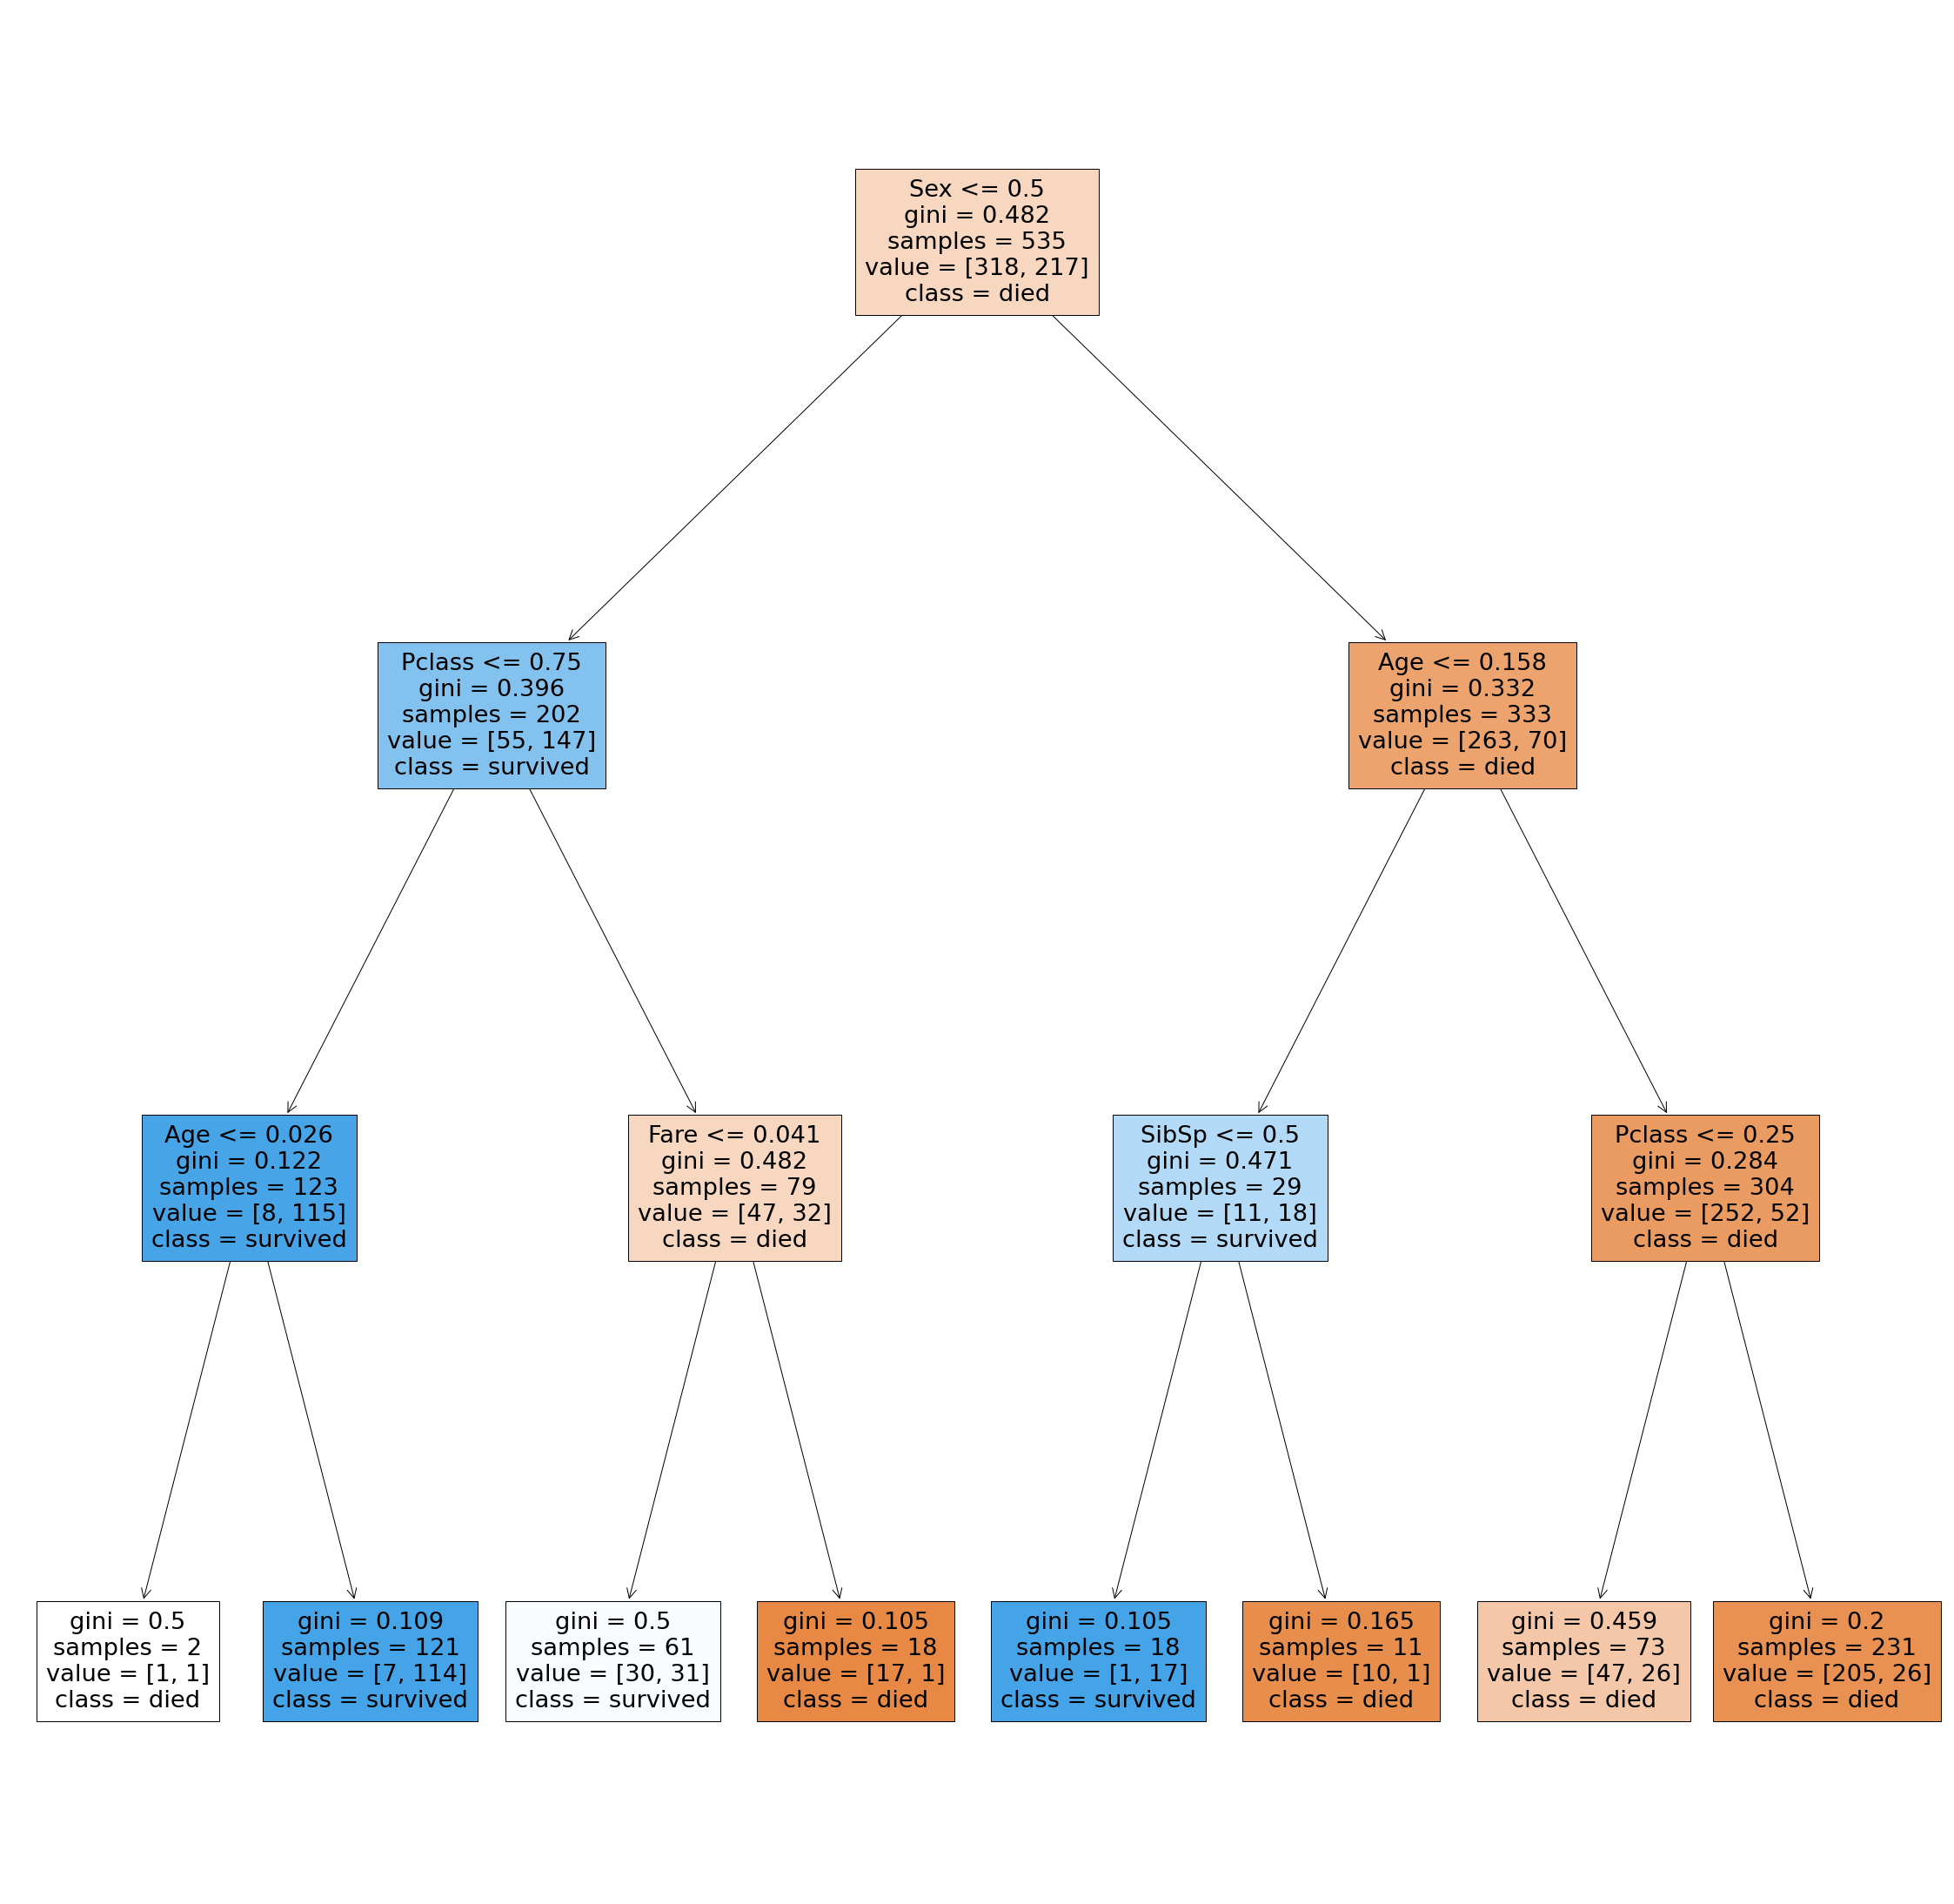

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import plot_tree

scaler = MinMaxScaler()
y = titanic_df["Survived"]
X = scaler.fit_transform(titanic_df.drop("Survived", axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

clf = DecisionTreeClassifier(random_state=0, max_depth=3)
clf.fit(X_train, y_train)
plt.figure(figsize=[40,40])

X_column = titanic_df.drop("Survived", axis=1)
plot_tree(clf, feature_names=X_column.columns, class_names={1: "survived", 0: "died"}, filled=True)

accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

From this decision tree, the previous hypotheses can be tested. For the ticket class averages, the decision tree confirms that lower ticket class people had a higher chance of surviving. For the age averages, the decision tree is a little bit more difficult to discern with age as an attribute. However, there is slight indication that younger aged passengers survived more than older passengers.

### kNN Classifier

In order to refine the machine learning model, kNN classification will be used to compare accuracy performance of different models. In order to get multiple performance numbers, models of 3 neighbors, 5 neighbors, and 7 neighbors will be constructed and tested.

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y = titanic_df["Survived"]
X = scaler.fit_transform(titanic_df.drop("Survived", axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

knn_clf = KNeighborsClassifier(n_neighbors=3, metric="euclidean")
knn_clf.fit(X_train, y_train)
accuracy = knn_clf.score(X_test, y_test)
print("Accuracy (3 neighbors):", accuracy)

knn_clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn_clf.fit(X_train, y_train)
accuracy = knn_clf.score(X_test, y_test)
print("Accuracy (5 neighbors):", accuracy)

knn_clf = KNeighborsClassifier(n_neighbors=7, metric="euclidean")
knn_clf.fit(X_train, y_train)
accuracy = knn_clf.score(X_test, y_test)
print("Accuracy (7 neighbors):", accuracy)

Accuracy (3 neighbors): 0.7988826815642458
Accuracy (5 neighbors): 0.776536312849162
Accuracy (7 neighbors): 0.7988826815642458


In addition to noting the significantly better performance from the decision tree, the accuracy varies for the various kNN classifiers. Though 3 and 7 neighbors share the same accuracy, it appears that using 5 neighbors slightly decreased the accuracy. This could potentially be a notable observation for future learning models that utilize kNN classification.